# Community similarities

This notebook focuses on detecting communities within the FriendFeed social network. We'll use the preprocessed datasets to build a graph and analyze community structures.

In [1]:
import os
import gc
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import dask.dataframe as dd
import matplotlib.pyplot as plt
from collections import Counter
from collections import defaultdict
from urllib.parse import urlparse
from networkx.algorithms.centrality import degree_centrality, betweenness_centrality

### 1. Load celaned input data

In [2]:
%%time
# Load preprocessed data
users = pd.read_parquet('processed_data/users_cleaned.parquet')
subs = pd.read_parquet('processed_data/subs_cleaned.parquet')
following = pd.read_parquet('processed_data/following_cleaned.parquet')
comments = pd.read_parquet('processed_data/comments_cleaned.parquet')
likes = pd.read_parquet('processed_data/likes_cleaned.parquet')
entries = pd.read_parquet('processed_data/entries_cleaned.parquet')

CPU times: user 30.3 s, sys: 17.4 s, total: 47.7 s
Wall time: 32.5 s


In [3]:
print(f'users columns: {list(users.columns)}')
print(f'subs columns: {list(subs.columns)}')
print(f'following columns: {list(following.columns)}')
print(f'comments columns: {list(comments.columns)}')
print(f'likes columns: {list(likes.columns)}')
print(f'entries columns: {list(entries.columns)}')

users columns: ['ID', 'Type', 'Name', 'Description']
subs columns: ['FollowerID', 'FollowedID']
following columns: ['FollowerID', 'FollowedID', 'Timestamp']
comments columns: ['PostID', 'EntryID', 'PostedBy', 'SourceURL', 'Timestamp', 'Text']
likes columns: ['userID', 'PostID', 'Timestamp']
entries columns: ['PostID', 'PostedBy', 'SourceURL', 'Timestamp', 'Text']


## 2. load the network from files

In [4]:
graph_3 = nx.read_gexf("graph/subgraph_3.gexf")
num_nodes = graph_3.number_of_nodes()
num_edges = graph_3.number_of_edges()

print("Number of Nodes:", num_nodes)
print("Number of Edges:", num_edges)

Number of Nodes: 12776
Number of Edges: 299677


In [5]:
graph_20 = nx.read_gexf("graph/subgraph_20.gexf")
num_nodes = graph_20.number_of_nodes()
num_edges = graph_20.number_of_edges()

print("Number of Nodes:", num_nodes)
print("Number of Edges:", num_edges)

Number of Nodes: 2442
Number of Edges: 12395


In [6]:
graph_11 = nx.read_gexf("graph/subgraph_11.gexf")
num_nodes = graph_11.number_of_nodes()
num_edges = graph_11.number_of_edges()

print("Number of Nodes:", num_nodes)
print("Number of Edges:", num_edges)

Number of Nodes: 2240
Number of Edges: 51294


In [7]:
graph_52 = nx.read_gexf("graph/subgraph_52.gexf")
num_nodes = graph_52.number_of_nodes()
num_edges = graph_52.number_of_edges()

print("Number of Nodes:", num_nodes)
print("Number of Edges:", num_edges)

Number of Nodes: 2138
Number of Edges: 25151


### 3. Analyze graphs

In [8]:
def print_head_data_for_graph(graph_nbr, head=5):
    node_attributes = {node: data for node, data in graph_nbr.nodes(data=True)}
    print(len(node_attributes))
    for key, value in list(node_attributes.items())[:head]:
        print(key, value)
    
    print("-----------------------------")
    edge_attributes = {(u, v): data for u, v, data in graph_nbr.edges(data=True)}
    print(len(edge_attributes))
    for (u, v), data in list(edge_attributes.items())[:head]:
        print(f"Edge: ({u}, {v}), Attributes: {data}")

In [9]:
def find_and_cound_edge_types(graph_nbr):
    relationship_counter = Counter()
    # Loop through the edges in graph_52 and access the 'relationship' attribute
    for _, _, data in graph_nbr.edges(data=True):
        if 'relationship' in data:
            relationship_counter[data['relationship']] += 1

    print(relationship_counter)

In [10]:
def find_distinct_node_names_with_specific_edge_type(graph_nbr, head=5):
    # Create a defaultdict to store nodes for each relationship type
    relationship_nodes = defaultdict(set)
    
    # Loop through the edges in the graph and categorize the nodes based on the 'relationship' attribute
    for u, v, data in graph_nbr.edges(data=True):
        if 'relationship' in data:
            relationship_type = data['relationship']
            # Add both nodes to the set for that relationship type
            relationship_nodes[relationship_type].add(u)
            relationship_nodes[relationship_type].add(v)
    
    for relationship, nodes in relationship_nodes.items():
        print(f"Relationship: '{relationship}' has {len(nodes)} number of distinct nodes!")
        print(f"* Nodes: {list(nodes)[:head]}...\n")  # Print only the first 3 nodes for brevity
    return relationship_nodes

In [11]:
def find_domain_for_relationship_nodes(relationship_nodes, comments, entries):
    """
    Find the domain part of the SourceURL for each node in the relationship_nodes dictionary.

    Args:
    - relationship_nodes: A dictionary where keys are relationship types, and values are sets of nodes.
    - comments: DataFrame containing 'PostedBy' and 'SourceURL' columns for comment data.
    - entries: DataFrame containing 'PostedBy' and 'SourceURL' columns for entry data.

    Returns:
    - nodes_with_domains: A dictionary where the keys are relationship types and the values are dictionaries
      mapping each node to its corresponding SourceURL domain (if available).
    """
    # Create a dictionary to store the domain for each node (if it exists)
    nodes_with_domains = defaultdict(dict)

    # Look up SourceURL in comments and entries DataFrames
    comments_sourceurl_dict = pd.Series(comments.SourceURL.values, index=comments.PostedBy).to_dict()
    entries_sourceurl_dict = pd.Series(entries.SourceURL.values, index=entries.PostedBy).to_dict()

    # Merge the two dictionaries to form a unified lookup table for SourceURL
    sourceurl_lookup = {**comments_sourceurl_dict, **entries_sourceurl_dict}

    # Function to extract the domain from a URL
    def extract_domain(url):
        try:
            parsed_url = urlparse(url)
            return f"{parsed_url.scheme}://{parsed_url.netloc}/" if parsed_url.scheme and parsed_url.netloc else None
        except Exception:
            return None

    # Iterate over each relationship type and corresponding nodes
    for relationship, nodes in relationship_nodes.items():
        for node in nodes:
            # Fetch the SourceURL for the node if it exists and extract the domain
            source_url = sourceurl_lookup.get(node, None)
            domain = extract_domain(source_url) if source_url else None
            nodes_with_domains[relationship][node] = domain

    return nodes_with_domains


In [12]:
def plot_domains_with_min_count(nodes_with_domains, n):
    """
    Plot domains that occur more than 'n' times in the nodes_with_domains dictionary.
    
    Args:
    - nodes_with_domains: A dictionary where keys are relationship types and values are dictionaries
      mapping nodes to their corresponding domain.
    - n: Minimum number of occurrences for a domain to be included in the plot.
    
    Returns:
    - None. Displays a bar plot and prints the number of nodes with None as their domain.
    """
    domain_counter = Counter()
    none_count = 0
    
    # Count occurrences of each domain, and track 'None' domains
    for relationship, node_domain_dict in nodes_with_domains.items():
        for node, domain in node_domain_dict.items():
            if domain is None:
                none_count += 1
            else:
                domain_counter[domain] += 1
    
    # Filter domains that appear more than 'n' times
    filtered_domains = {domain: count for domain, count in domain_counter.items() if count > n}
    
    # Print the number of nodes with None domains
    print(f"Number of nodes with None as their domain: {none_count}")
    
    # Plot the filtered domains
    if filtered_domains:
        plt.figure(figsize=(10, 6))
        plt.barh(filtered_domains.keys(), filtered_domains.values(), color='skyblue')
        plt.xticks(rotation=45, ha='right')
        plt.xlabel('Domain')
        plt.ylabel('Count')
        plt.title(f"Domains with More Than {n} Occurrences")
        plt.tight_layout()
        plt.show()
    else:
        print(f"No domains found with more than {n} occurrences.")


In [13]:
def detect_Influencers_in_graph(graph_52):
    """
    - Degree_centrality measures how many edges (connections) a node has to other nodes. 
        Nodes with high degree centrality are those that are directly connected to many other nodes. 
        They act as "hubs" in the network.
    - Betweenness_centrality measures how often a node lies on the shortest path between 
        two other nodes in the network.
        Nodes with high betweenness centrality act as bridges between different parts of the network and play a key role in facilitating communication or information flow
    """
    degree_cent = degree_centrality(graph_52)
    betweenness_cent = betweenness_centrality(graph_52)
    
    # Find top 5 central nodes based on degree centrality
    i = 0
    central_nodes_by_degree = sorted(degree_cent.items(), key=lambda x: x[1], reverse=True)
    print("Top 5 central nodes by degree centrality with scores:")
    for node, score in central_nodes_by_degree:
        print(f" * Node: {node}, Degree Centrality: {score}")
        i += 1
        if i == 5:
            break
    
    # Find top 5 central nodes based on betweenness centrality
    i = 0
    central_nodes_by_betweenness = sorted(betweenness_cent.items(), key=lambda x: x[1], reverse=True)
    print("\nTop 5 central nodes by betweenness centrality with scores:")
    for node, score in central_nodes_by_betweenness:
        print(f" * Node: {node}, Betweenness Centrality: {score}")
        i += 1
        if i == 5:
            break

    return central_nodes_by_degree, central_nodes_by_betweenness

In [14]:
def plot_Influencers_in_graph(graph_nbr, central_nodes_by_degree, central_nodes_by_betweenness, spread_factor=2, top_betweenness=100, top_degree=100):
    """
    Detect and visualize influencers in the graph based on degree centrality (node size) 
    and betweenness centrality (node color).
    
    Args:
    - graph_nbr: The networkx graph to visualize.
    - central_nodes_by_degree: List of top nodes by degree centrality (node_name, degree_score).
    - central_nodes_by_betweenness: List of top nodes by betweenness centrality (node_name, betweenness_score).
    - spread_factor: Controls how far apart the nodes are spread (default is 2, increase to spread further).
    - top_betweenness: Number of top nodes by betweenness centrality to color red (default is 100).
    - top_degree: Number of top nodes by degree centrality to scale up in size (default is 100).
    """
    # Plot all nodes in the graph
    nodes_to_plot = set(graph_nbr.nodes())
    
    # Create a dictionary for degree centrality scores (for node sizes)
    degree_cent_dict = dict(central_nodes_by_degree)
    
    # Create a set of the top `top_degree` nodes by degree centrality
    top_degree_nodes_scaled = {node for node, _ in central_nodes_by_degree[:top_degree]}
    
    # Create node sizes: multiply only for the `top_degree` nodes by degree centrality, use default for others
    node_sizes = [(degree_cent_dict.get(node, 0.1) * 800 if node in top_degree_nodes_scaled else degree_cent_dict.get(node, 0.1) * 100) 
                  for node in nodes_to_plot]  # Default size for others is 100
    
    # Create a set of the `top_betweenness` nodes by betweenness centrality
    top_betweenness_nodes_red = {node for node, _ in central_nodes_by_betweenness[:top_betweenness]}
    
    # Create node colors: red for the top `top_betweenness` betweenness nodes, blue for others
    node_colors = ['red' if node in top_betweenness_nodes_red else 'blue' for node in nodes_to_plot]
    
    # Draw the graph with node sizes and colors
    plt.figure(figsize=(10, 10))
    
    # Adjust spring layout to make nodes more spread out
    pos = nx.spring_layout(graph_nbr, k=spread_factor / np.sqrt(len(nodes_to_plot)))  # Adjust spread_factor
    
    nx.draw_networkx_nodes(graph_nbr, pos, nodelist=nodes_to_plot, node_size=node_sizes, node_color=node_colors, alpha=0.6)
    nx.draw_networkx_edges(graph_nbr, pos, alpha=0.01)
    # Optionally, add labels to the nodes
    # nx.draw_networkx_labels(graph_nbr, pos, font_size=8, labels={n: n for n in nodes_to_plot})

    # Add legend
    red_patch = plt.Line2D([0], [0], marker='o', color='w', label=f'Top {top_betweenness} Betweenness Nodes (Red)', 
                           markerfacecolor='red', markersize=10)
    blue_patch = plt.Line2D([0], [0], marker='o', color='w', label='Other Nodes (Blue)', 
                            markerfacecolor='blue', markersize=10)
    
    plt.legend(handles=[red_patch, blue_patch], loc="best")
    
    # Add title
    plt.title(f"Graph Visualization with Influencers Highlighted")
    plt.show()

    return central_nodes_by_degree, central_nodes_by_betweenness


## RESULT

### 4. Analyze graph_52

In [15]:
print_head_data_for_graph(graph_52)

2138
johanlipeckiwestin {'community': 52, 'label': 'johanlipeckiwestin'}
vesakotilainen {'community': 52, 'label': 'vesakotilainen'}
smyrnakyrkan {'community': 52, 'label': 'smyrnakyrkan'}
chrisaliaga {'community': 52, 'label': 'chrisaliaga'}
haflidason {'community': 52, 'label': 'haflidason'}
-----------------------------
25151
Edge: (johanlipeckiwestin, jonathanstara), Attributes: {'relationship': 'subs', 'id': '0'}
Edge: (johanlipeckiwestin, doktorspinn), Attributes: {'relationship': 'subs', 'id': '1'}
Edge: (vesakotilainen, tieke), Attributes: {'relationship': 'subs', 'id': '2'}
Edge: (smyrnakyrkan, joegus), Attributes: {'relationship': 'subs', 'id': '3'}
Edge: (smyrnakyrkan, lydiamorling), Attributes: {'relationship': 'subs', 'id': '4'}


In [16]:
find_and_cound_edge_types(graph_52)

Counter({'subs': 18335, 'following': 6799, 'comment': 10, 'like': 7})


In [17]:
relationship_nodes = find_distinct_node_names_with_specific_edge_type(graph_52, head=4)

Relationship: 'subs' has 2137 number of distinct nodes!
* Nodes: ['deeped', 'joelwidengren', 'pietro1', 'trang1']...

Relationship: 'following' has 1146 number of distinct nodes!
* Nodes: ['deeped', 'tomsun', 'hoferma', 'himmelochord']...

Relationship: 'comment' has 16 number of distinct nodes!
* Nodes: ['jesperastrom', 'deeped', 'm00ns2', 'pelles']...

Relationship: 'like' has 11 number of distinct nodes!
* Nodes: ['arongas', 'm00ns2', 'armi', 'jardenberg']...



In [18]:
central_nodes_by_degree, central_nodes_by_betweenness = detect_Influencers_in_graph(graph_52);

Top 5 central nodes by degree centrality with scores:
 * Node: jardenberg, Degree Centrality: 0.3406644829199813
 * Node: mymlan, Degree Centrality: 0.270004679457183
 * Node: jonasl, Degree Centrality: 0.22882545624707534
 * Node: deeped, Degree Centrality: 0.21993448759943848
 * Node: gunnar, Degree Centrality: 0.21619092185306504

Top 5 central nodes by betweenness centrality with scores:
 * Node: jardenberg, Betweenness Centrality: 0.09270793816763509
 * Node: wheelforce, Betweenness Centrality: 0.08816202331683125
 * Node: oskariuotinen, Betweenness Centrality: 0.08136893335786771
 * Node: richardgatarski, Betweenness Centrality: 0.042023944509025614
 * Node: jussikuortti, Betweenness Centrality: 0.03524043505698201


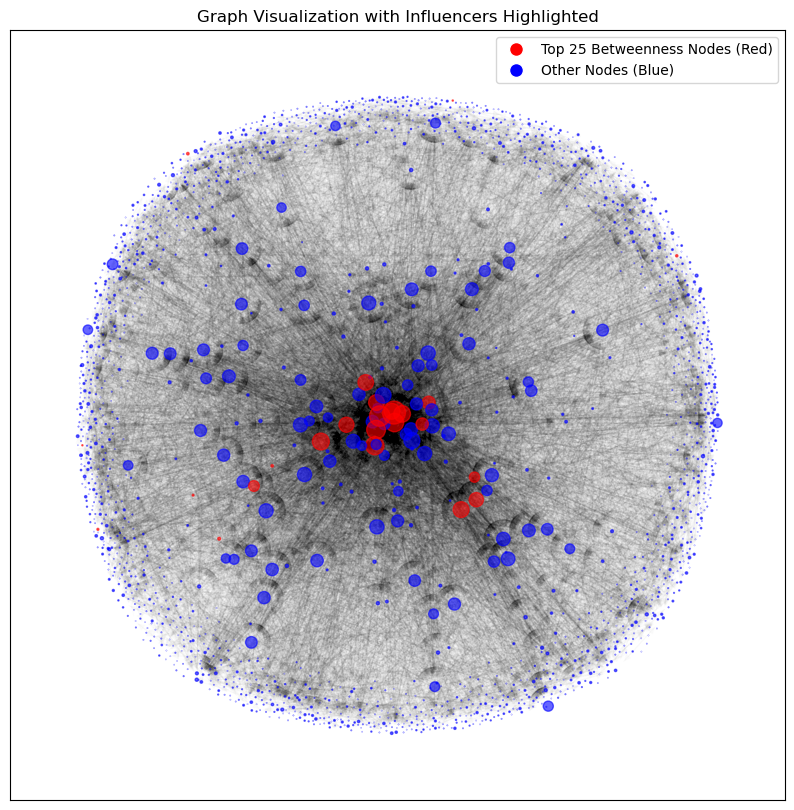

CPU times: user 2min 50s, sys: 2.15 s, total: 2min 52s
Wall time: 2min 33s


In [19]:
%%time
plot_Influencers_in_graph(graph_52, central_nodes_by_degree, central_nodes_by_betweenness, spread_factor=50, top_betweenness=25, top_degree=100);

In [20]:
nodes_with_domains = find_domain_for_relationship_nodes(relationship_nodes, comments, entries);

Number of nodes with None as their domain: 1825


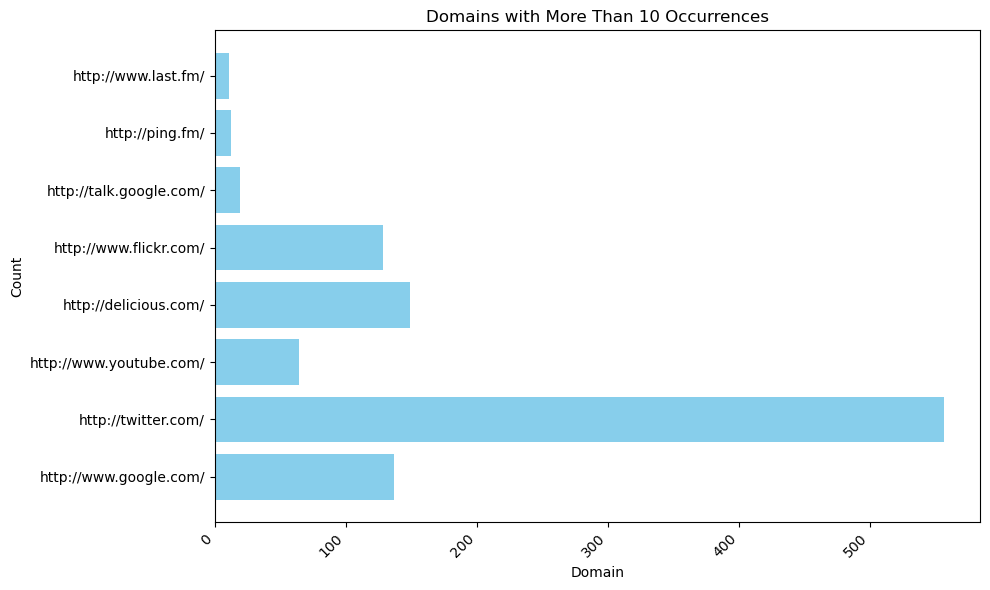

In [21]:
plot_domains_with_min_count(nodes_with_domains, 10)

In [89]:
def plot_most_active_person(central_nodes_by_degree, spread_factor=2):
    """
    Plot the most active person (central node) and all their connections,
    highlighting the central node and edges directly connected to it.
    
    Args:
    - spread_factor: Controls how far apart the nodes are spread (default is 2, increase to spread further).
    """
    # Step 1: Find the most active person (central node)
    user_name = central_nodes_by_degree[:1][0][0]
    
    # Step 2: Find all followers of the most active person
    most_active_followers = following[following['FollowedID'] == user_name]
    
    # Step 3: Get the list of follower IDs
    follower_ids = most_active_followers['FollowerID'].compute()
    
    # Step 4: Create a graph using NetworkX
    G = nx.Graph()
    
    # Add edges between the most active person and each of their followers
    for follower in follower_ids:
        G.add_edge(user_name, follower)
    
    # Add edges for all connections (assuming you want all edges from the following DataFrame)
    for _, row in connections_df.iterrows():
        G.add_edge(row['FollowerID'], row['FollowedID'])
    
    # Step 5: Visualize the graph
    plt.figure(figsize=(8, 8))
    pos = nx.spring_layout(G, k=spread_factor, iterations=50)  # Layout for better visibility
    
    # Draw all nodes
    nx.draw_networkx_nodes(G, pos, node_size=50, node_color='blue', alpha=0.5)
    
    # Draw the most active person in red with larger size
    nx.draw_networkx_nodes(G, pos, nodelist=[user_name], node_size=150, node_color='red', alpha=0.8)
    
    # Draw the edges with the most active person's edges as green
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(user_name), edge_color='black', alpha=0.4)
    
    # Draw the remaining edges in light gray
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color='lightblue', alpha=0.2)

    plt.title(f'Connections of user "{user_name}" with its {len(most_active_followers)} followers')
    plt.axis('off')  # Turn off the axis
    plt.show()


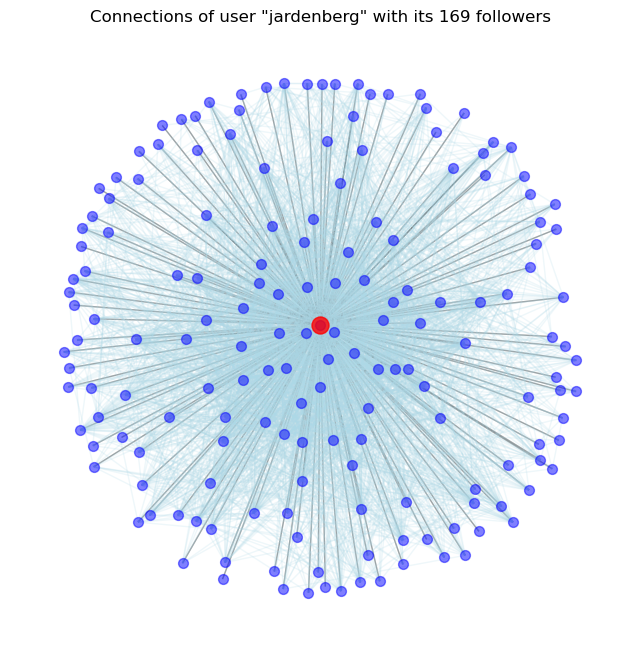

CPU times: user 4.86 s, sys: 2.68 s, total: 7.54 s
Wall time: 7.07 s


In [90]:
%%time
plot_most_active_person(central_nodes_by_degree)